<a href="https://colab.research.google.com/github/Rohanrathod7/Kaggle_Notebooks/blob/main/anaverse/raw_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import os
import time
import warnings

import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

!pip install optuna # Install optuna
import optuna
from tqdm.notebook import tqdm
import lightgbm as lgb
import xgboost as xgb

import sklearn
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay
)


In [53]:
import pandas as pd
from google.colab import drive

# ====================================================
# Setup & Imports
# ====================================================

import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings for cleaner output and consistent plotting
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8) # Default figure size for plots

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("Setup complete: Warnings suppressed, plotting styles set, and reproducibility ensured.")

# --- Data Loading and Initial Inspection ---

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the file paths, assuming they are in a subfolder like 'Colab Notebooks' within My Drive
train_path = '/content/drive/MyDrive/Kaggle/anaverse/train.parquet'
test_path = '/content/drive/MyDrive/Kaggle/anaverse/test.parquet'
sample_submission_path = '/content/drive/MyDrive/Kaggle/anaverse/sample_submission.parquet'

# 3. Load train.csv into a pandas DataFrame named df_train
df_train = pd.read_parquet(train_path)

# 4. Load test.csv into a pandas DataFrame named df_test
df_test = pd.read_parquet(test_path)


Setup complete: Warnings suppressed, plotting styles set, and reproducibility ensured.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
def reduce_memory(df:pd.DataFrame, verbose:bool=True) -> pd.DataFrame:
    original_memory = (df.memory_usage().sum()) / (1024 ** 2)

    for column in df.columns:
        column_dtype = df[column].dtype

        if (column_dtype != object) and (column_dtype != str):
            if (str(column_dtype) + '______')[:3] == 'int':
                df[column] = df[column].astype(np.int32)
            if (str(column_dtype) + '______')[:5] == 'float':
                df[column] = df[column].astype(np.float32)

    if verbose:
        print('-----------------------------------------------------')
        print(f'Memory usage of dataframe:\t\t{original_memory:.2f} MB')

        altered_memory = df.memory_usage().sum() / 1024**2
        print(f'Memory usage after dtype conversion:\t{altered_memory:.2f} MB')

        memory_variance = 100 * (original_memory - altered_memory) / original_memory
        print(f'Memory consumption decreased by:\t{memory_variance:.2f}%')
        print('-----------------------------------------------------')

    return df

# Apply the memory reduction to df_train and df_test
print("Applying memory reduction to df_train:")
df_train = reduce_memory(df_train)

print("\nApplying memory reduction to df_test:")
df_test = reduce_memory(df_test)

print('\nView first 5 rows in dataset df_train...\n')
print(df_train.head(5)) # Changed to print() to ensure output is shown

print('\nView first 5 rows in dataset df_test...\n')
print(df_test.head(5)) # Changed to print() to ensure output is shown


Applying memory reduction to df_train:
-----------------------------------------------------
Memory usage of dataframe:		87.55 MB
Memory usage after dtype conversion:	56.29 MB
Memory consumption decreased by:	35.71%
-----------------------------------------------------

Applying memory reduction to df_test:
-----------------------------------------------------
Memory usage of dataframe:		21.89 MB
Memory usage after dtype conversion:	12.51 MB
Memory consumption decreased by:	42.86%
-----------------------------------------------------

View first 5 rows in dataset df_train...

        Date        X1        X2   X3        X4        X5 target
0 2020-12-16  1.518921  5.463154  1.0  2.718282  2.890372      0
1 2020-12-16  1.546509  5.458010  1.0  2.718282  2.833213      1
2 2020-12-16  1.645427  5.456560  1.0  7.389056  2.890372      1
3 2020-12-16  1.652022  5.458478  1.0  2.718282  2.890372      1
4 2020-12-16  1.695538  5.466709  1.0  2.718282  2.890372      0

View first 5 rows in datas

# Manual EDA

In [55]:
def data_info(df, df_name):
    """Comprehensive overview of a DataFrame with styled output."""

    print(f"\n{'='*80}")
    print(f"📊 Comprehensive Information for DataFrame: {df_name}")
    print(f"{'='*80}\n")

    # --- Shape ---
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

    # --- Head ---
    print(f"--- {df_name} Head ---\n")
    display(df.head().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Column Summary ---
    print(f"\n--- {df_name} Column Summary ---\n")
    summary = pd.DataFrame({
        "DataType": df.dtypes,
        "Non-Null Count": df.notnull().sum(),
        "Unique Values": df.nunique(),
        "Missing Values": df.isnull().sum(),
        "Missing %": (df.isnull().sum() / len(df)) * 100
    })
    display(summary.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Describe (numeric only) ---
    if df.select_dtypes(include=np.number).shape[1] > 0:
        print(f"\n--- {df_name} Numeric Summary ---\n")
        display(df.describe().style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    # --- Describe (categorical only) ---
    cat_cols = df.select_dtypes(exclude=np.number).columns
    if len(cat_cols) > 0:
        print(f"\n--- {df_name} Categorical Summary ---\n")
        cat_summary = df[cat_cols].describe().transpose()
        display(cat_summary.style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    # --- Target Column Summary (Added based on user request in cell e278708d) ---
    if 'target' in df.columns:
        print(f"\n--- {df_name} 'target' Column Distribution ---\n")
        target_counts = df['target'].value_counts()
        target_percentages = df['target'].value_counts(normalize=True) * 100
        target_summary_df = pd.DataFrame({
            'Count': target_counts,
            'Percentage': target_percentages
        })
        display(target_summary_df.style.set_caption("Value Counts and Percentages for 'target'"))


    print(f"\n{'='*80}\n")

# Apply
data_info(df_train, "df_train")
data_info(df_test, "df_test")



📊 Comprehensive Information for DataFrame: df_train

Shape: 1639424 rows × 7 columns

--- df_train Head ---



,Date,X1,X2,X3,X4,X5,target
0,2020-12-16 00:00:00,1.518921,5.463154,1.000000,2.718282,2.890372,0
1,2020-12-16 00:00:00,1.546509,5.458010,1.000000,2.718282,2.833213,1
2,2020-12-16 00:00:00,1.645427,5.456560,1.000000,7.389056,2.890372,1
3,2020-12-16 00:00:00,1.652022,5.458478,1.000000,2.718282,2.890372,1
4,2020-12-16 00:00:00,1.695538,5.466709,1.000000,2.718282,2.890372,0



--- df_train Column Summary ---



,DataType,Non-Null Count,Unique Values,Missing Values,Missing %
Date,datetime64[ns],1639424,1432,0,0.000000
X1,float32,1639424,526,0,0.000000
X2,float32,1639424,2812,0,0.000000
X3,float32,1639424,88,0,0.000000
X4,float32,1639424,81,0,0.000000
X5,float32,1639424,32,0,0.000000
target,object,1639424,2,0,0.000000



--- df_train Numeric Summary ---



,Date,X1,X2,X3,X4,X5
count,1639424,1639424.000000,1639424.000000,1639424.000000,1639424.000000,1639424.000000
mean,2022-12-03 07:23:43.817145600,1.139259,5.488189,inf,270632192930717418215037730816.000000,1.187219
min,2020-12-16 00:00:00,1.000000,5.412539,1.000000,1.000000,0.000000
25%,2021-12-10 00:00:00,1.049171,5.480597,1.000000,1.000000,0.000000
50%,2022-11-30 00:00:00,1.105171,5.488979,1.000000,1.000000,0.693147
75%,2023-11-23 00:00:00,1.214096,5.496717,1.000000,2.718282,2.890372
max,2024-12-11 00:00:00,4.014850,5.541852,165163626613613066163770348909654704128.000000,55406224846767593604562923875729408.000000,3.465736
std,nan,0.138931,0.017309,inf,inf,1.307598



--- df_train Categorical Summary ---



,count,mean,min,25%,50%,75%,max
Date,1639424,2022-12-03 07:23:43.817145600,2020-12-16 00:00:00,2021-12-10 00:00:00,2022-11-30 00:00:00,2023-11-23 00:00:00,2024-12-11 00:00:00



--- df_train 'target' Column Distribution ---



,Count,Percentage
target,,
0,1625386,99.143724
1,14038,0.856276





📊 Comprehensive Information for DataFrame: df_test

Shape: 409856 rows × 7 columns

--- df_test Head ---



,ID,Date,X1,X2,X3,X4,X5
0,0,2020-12-16 00:00:00,1.685395,5.463917,1.000000,7.389056,2.890372
1,1,2020-12-16 00:00:00,1.488844,5.454937,1.000000,7.389056,2.890372
2,2,2020-12-16 00:00:00,1.164160,5.471136,1.000000,1.000000,2.890372
3,3,2020-12-16 00:00:00,1.000000,5.467385,1.000000,1.000000,2.890372
4,4,2020-12-16 00:00:00,1.000000,5.453995,1.000000,1.000000,2.833213



--- df_test Column Summary ---



,DataType,Non-Null Count,Unique Values,Missing Values,Missing %
ID,int32,409856,409856,0,0.000000
Date,datetime64[ns],409856,1432,0,0.000000
X1,float32,409856,459,0,0.000000
X2,float32,409856,2614,0,0.000000
X3,float32,409856,83,0,0.000000
X4,float32,409856,80,0,0.000000
X5,float32,409856,32,0,0.000000



--- df_test Numeric Summary ---



,ID,Date,X1,X2,X3,X4,X5
count,409856.000000,409856,409856.000000,409856.000000,409856.000000,409856.000000,409856.000000
mean,204927.500000,2022-12-03 08:15:48.485321216,1.139317,5.488174,154452681870381401622563168190464.000000,485770421721822843151788802048.000000,1.190927
min,0.000000,2020-12-16 00:00:00,1.000000,5.415433,1.000000,1.000000,0.000000
25%,102463.750000,2021-12-10 00:00:00,1.049171,5.480556,1.000000,1.000000,0.000000
50%,204927.500000,2022-11-30 00:00:00,1.105171,5.488979,1.000000,1.000000,0.693147
75%,307391.250000,2023-11-23 00:00:00,1.214096,5.496717,1.000000,2.718282,2.890372
max,409855.000000,2024-12-11 00:00:00,3.455613,5.539890,60760303473996161125322321925848956928.000000,55406224846767593604562923875729408.000000,3.465736
std,118315.380301,nan,0.138942,0.014969,inf,inf,1.305802



--- df_test Categorical Summary ---



,count,mean,min,25%,50%,75%,max
Date,409856,2022-12-03 08:15:48.485321216,2020-12-16 00:00:00,2021-12-10 00:00:00,2022-11-30 00:00:00,2023-11-23 00:00:00,2024-12-11 00:00:00


## Connection to Anomalies:
during anomaly periods (target=1), the values for X3 and X4 exhibit drastic shifts and become astronomically high. These inf and extremely large numbers are precisely these anomalous readings. They are not random noise but rather strong signals that something unusual is happening in the system when an anomaly occurs.

## Why X3 and X4 are similar:
The numeric summaries show a similar pattern for both X3 and X4 because both features seem to react similarly and intensely during anomalous events. They both produce these extremely high magnitudes when target=1, making them highly discriminative features for anomaly detection.

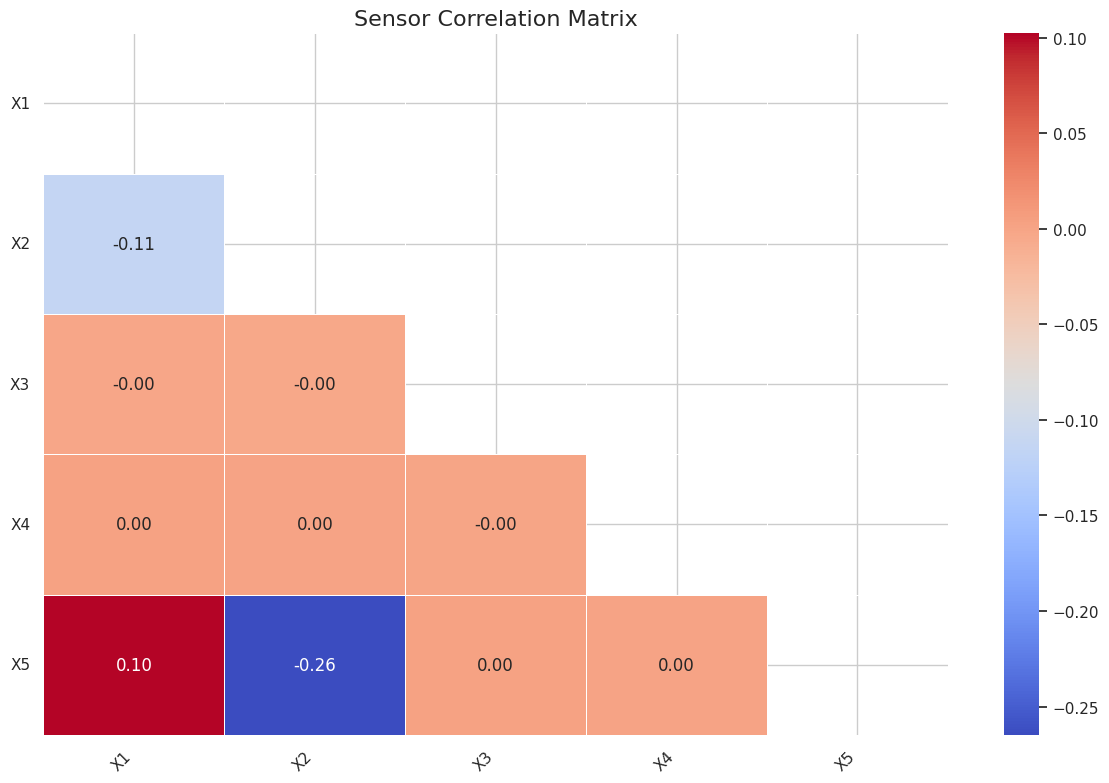

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the numerical features to include sensor columns (X1-X5)
numerical_features = ['X1', 'X2', 'X3', 'X4', 'X5']

# Calculate the Pearson correlation matrix for numerical features
correlation_matrix = df_train[numerical_features].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap with diverging colormap, masked upper triangle, and annotations
plt.figure(figsize=(12, 8)) # Use the global default figure size
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm', # Diverging colormap
    fmt=".2f",
    mask=mask, # Apply the mask
    linewidths=.5 # Add lines between cells for better separation
)
plt.title('Sensor Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



📌 X1 Summary Statistics:


,Train,Test
Mean,1.139259,1.139317
Median,1.105171,1.105171
Std,0.138931,0.138942


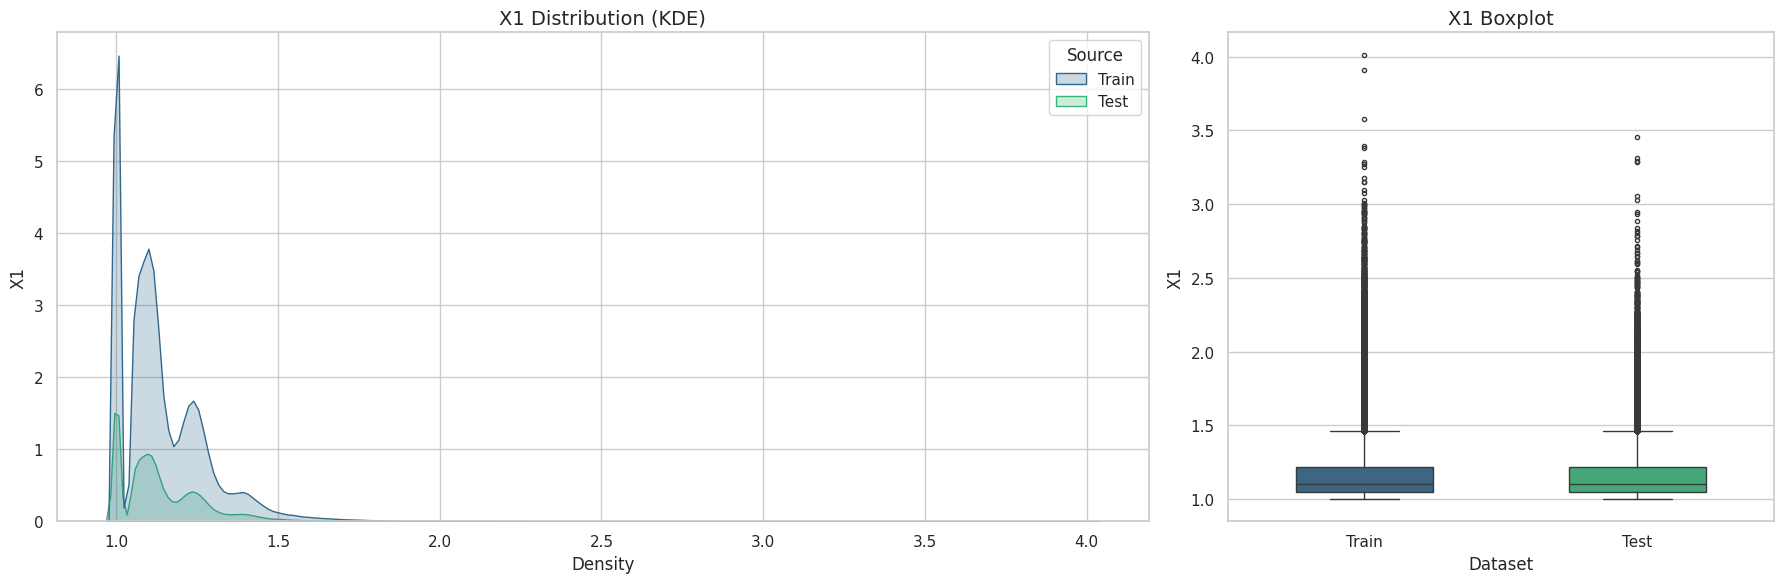


📌 X2 Summary Statistics:


,Train,Test
Mean,5.488189,5.488174
Median,5.488979,5.488979
Std,0.017309,0.014969


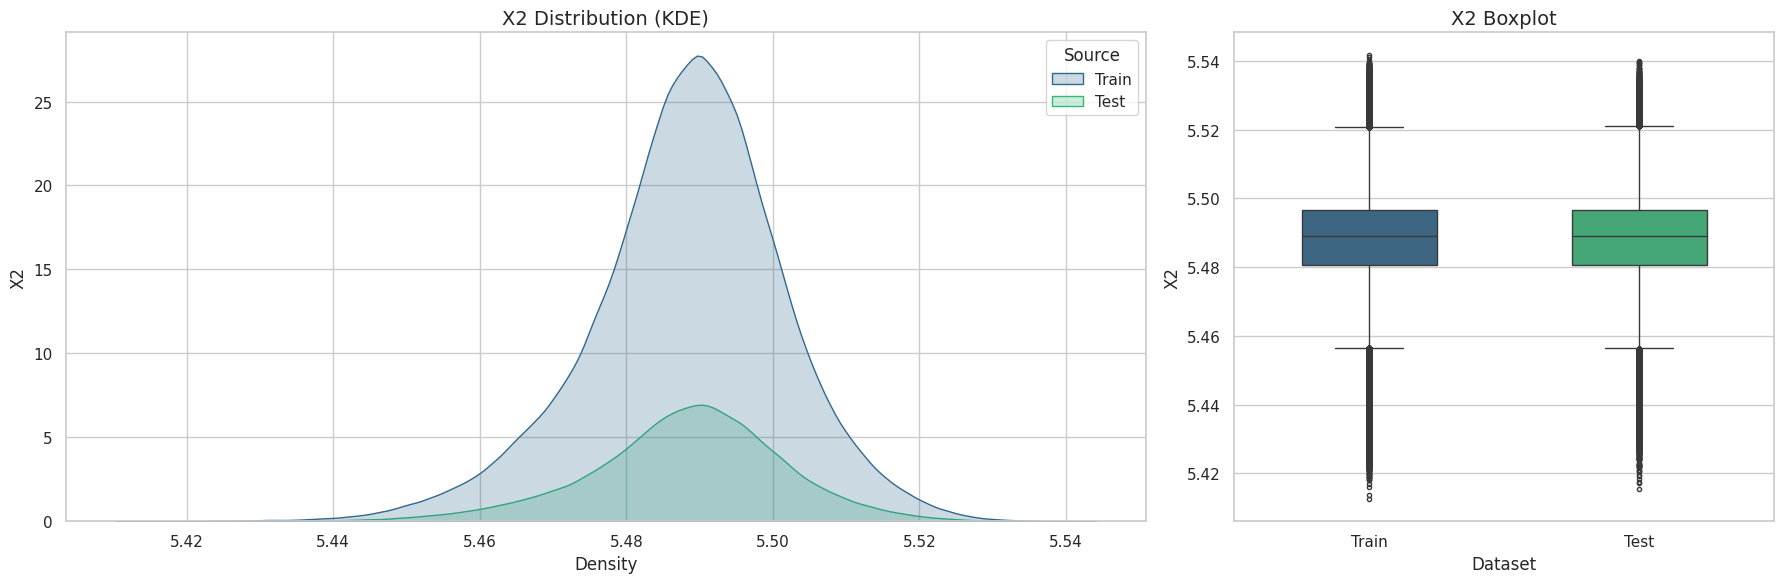


📌 X3 Summary Statistics:


,Train,Test
Mean,inf,1.544527e+32
Median,1.0,1.000000e+00
Std,inf,inf


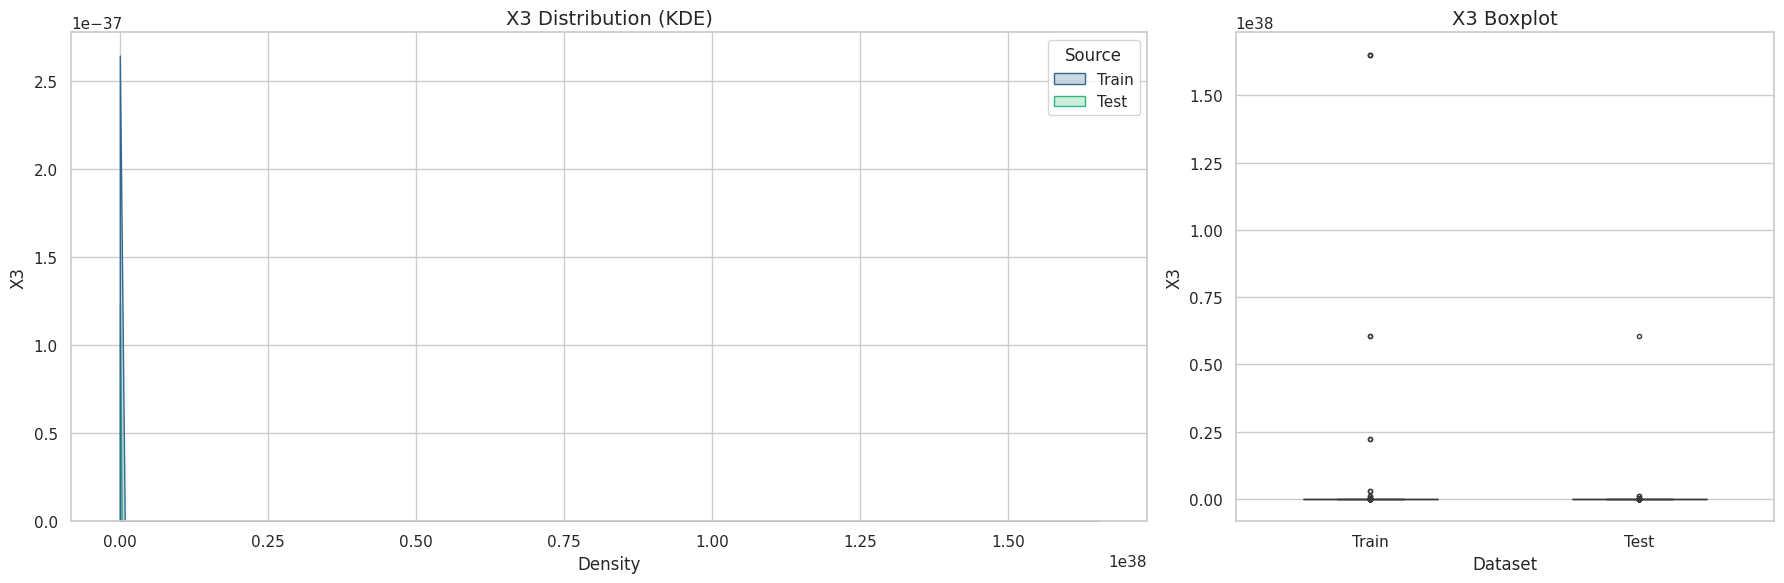


📌 X4 Summary Statistics:


,Train,Test
Mean,2.706322e+29,4.857704e+29
Median,1.000000e+00,1.000000e+00
Std,inf,inf


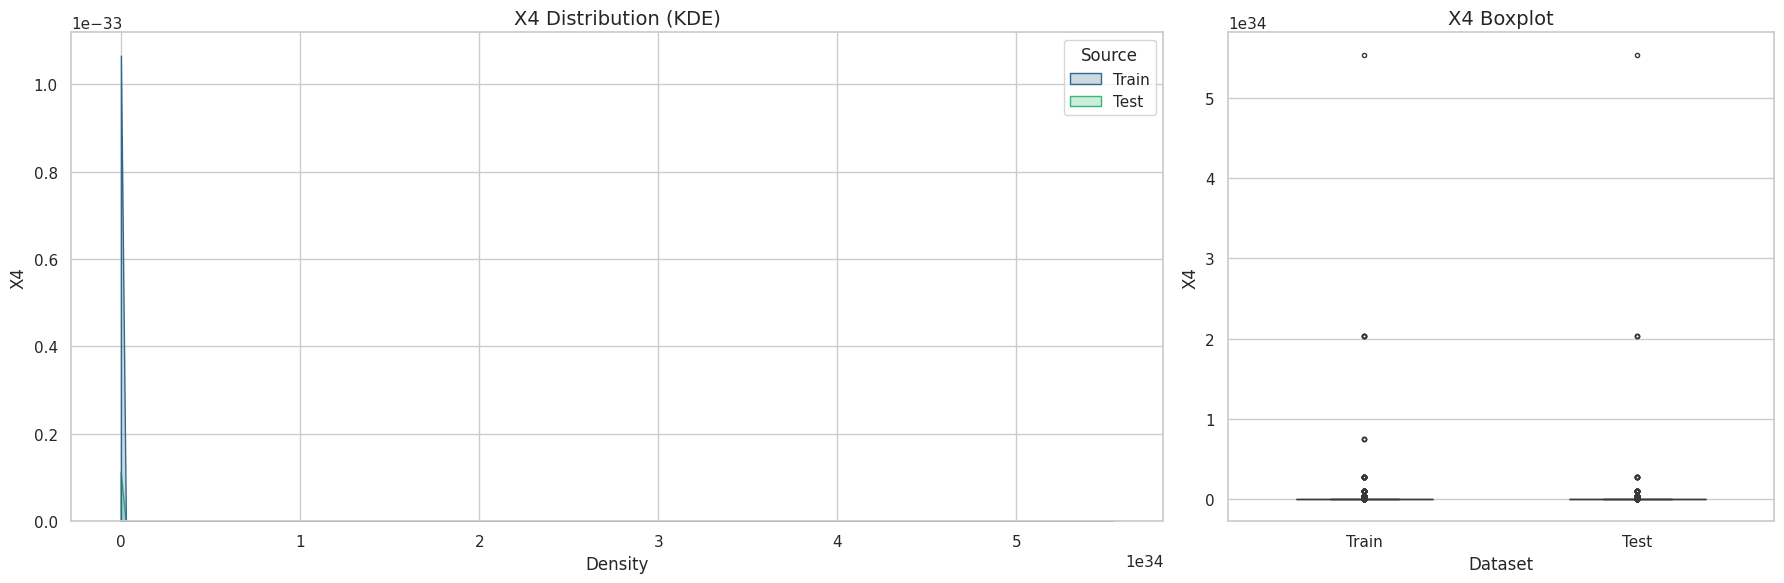


📌 X5 Summary Statistics:


,Train,Test
Mean,1.187219,1.190927
Median,0.693147,0.693147
Std,1.307598,1.305802


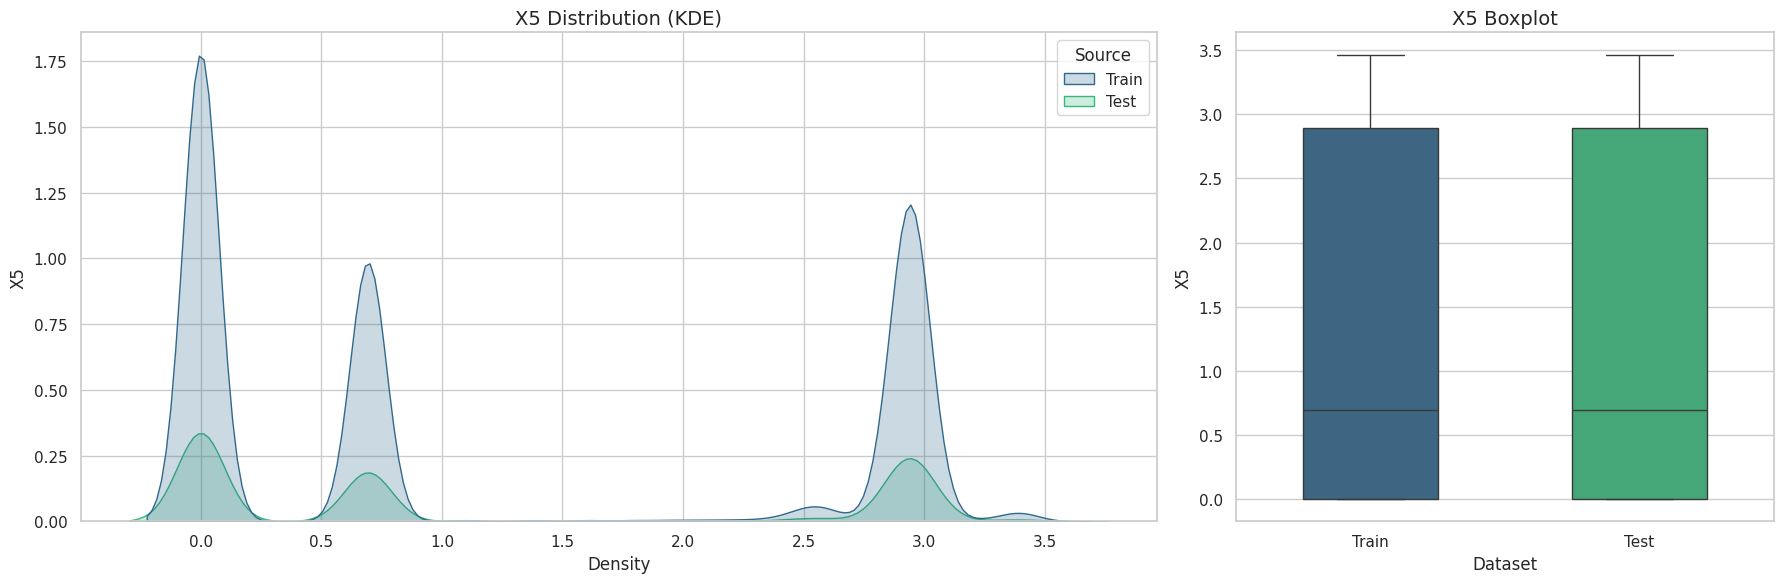

In [57]:
def plot_numerical_distributions(train_df, test_df, numerical_cols):
    """
    Generates KDE and box plots for numerical features, comparing train vs test distributions,
    with summary statistics printed.
    """
    sns.set_style("whitegrid")
    sns.set_context("notebook")

    # Combine train and test for plotting
    combined_df = pd.concat([
        train_df[numerical_cols].assign(Source='Train'),
        test_df[numerical_cols].assign(Source='Test')
    ], axis=0, ignore_index=True)

    palette = ['#1f77b4', '#ff7f0e']  # Distinct colors for Train/Test

    for col in numerical_cols:
        # Summary Stats
        print(f"\n📌 {col} Summary Statistics:")
        display(pd.DataFrame({
            'Train': [train_df[col].mean(), train_df[col].median(), train_df[col].std()],
            'Test': [test_df[col].mean(), test_df[col].median(), test_df[col].std()]
        }, index=['Mean', 'Median', 'Std']))

        fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1]})

        # KDE Plot
        sns.kdeplot(
            data=combined_df, x=col, hue='Source', ax=axes[0], fill=True, palette="viridis"
        )
        axes[0].set_title(f'{col} Distribution (KDE)', fontsize=14)
        axes[0].set_xlabel('Density')
        axes[0].set_ylabel(col)

        # Box Plot
        sns.boxplot(
            data=combined_df, y=col, x='Source', ax=axes[1],
            orient='v', width=0.5, linewidth=1, fliersize=3, palette="viridis"
        )
        axes[1].set_title(f'{col} Boxplot', fontsize=14)
        axes[1].set_xlabel('Dataset')
        axes[1].set_ylabel(col)

        plt.tight_layout()
        plt.show()

# Call numerical distribution function
plot_numerical_distributions(df_train, df_test, numerical_features)


📌 X1 Summary Statistics by target:


,mean,median,std
target,,,
0,1.138015,1.105171,0.137469
1,1.283204,1.241102,0.232147


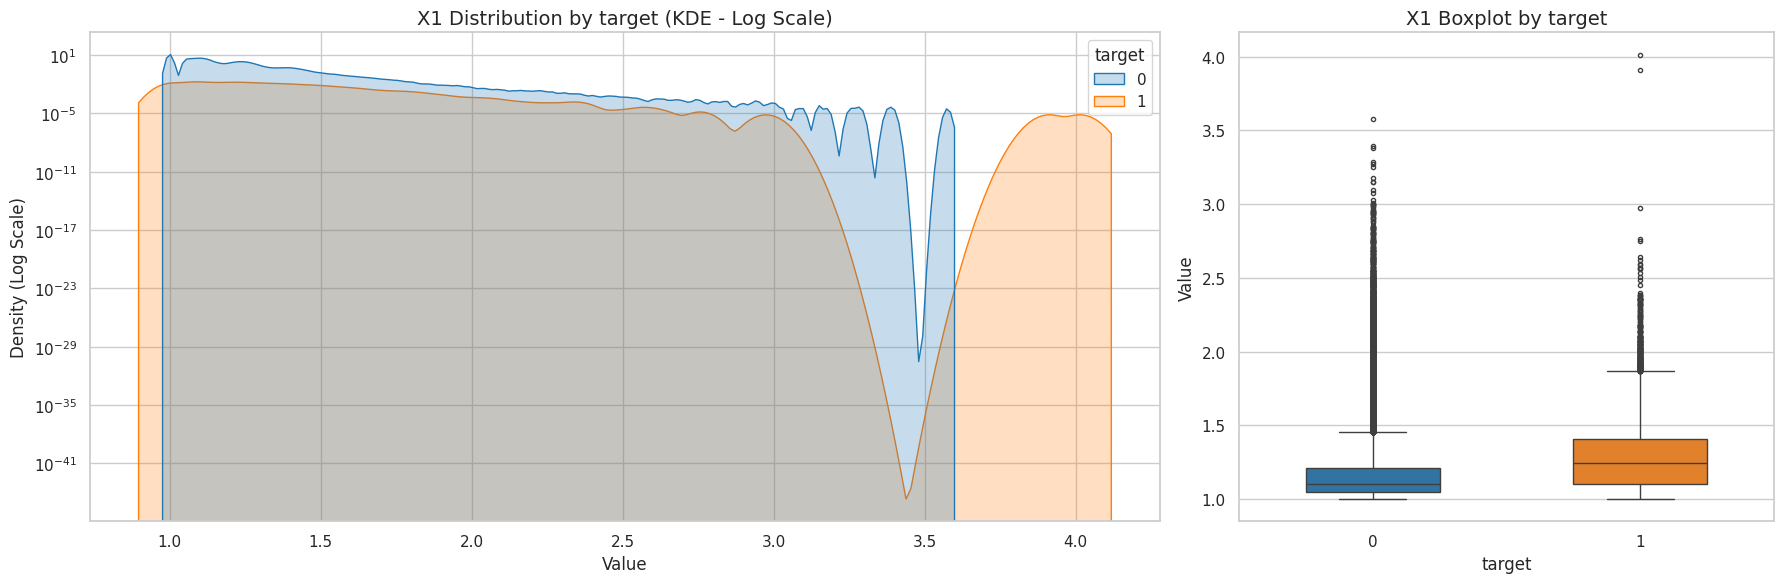


📌 X2 Summary Statistics by target:


,mean,median,std
target,,,
0,5.488392,5.489103,0.013247
1,5.464604,5.464806,0.013328


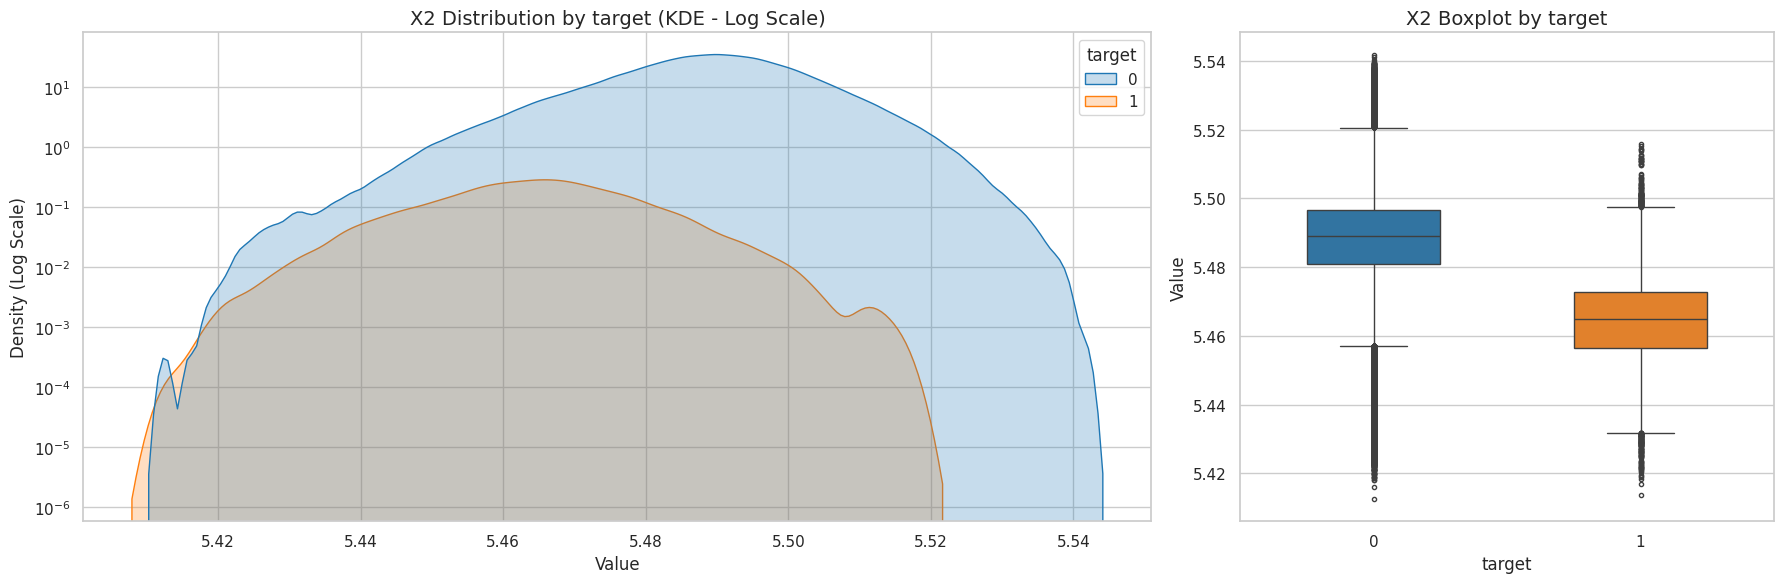


📌 X3 Summary Statistics by target:


,mean,median,std
target,,,
0,9.880565e+25,1.000000e+00,6.872742e+28
1,NaN,4.311232e+15,2.535059e+36


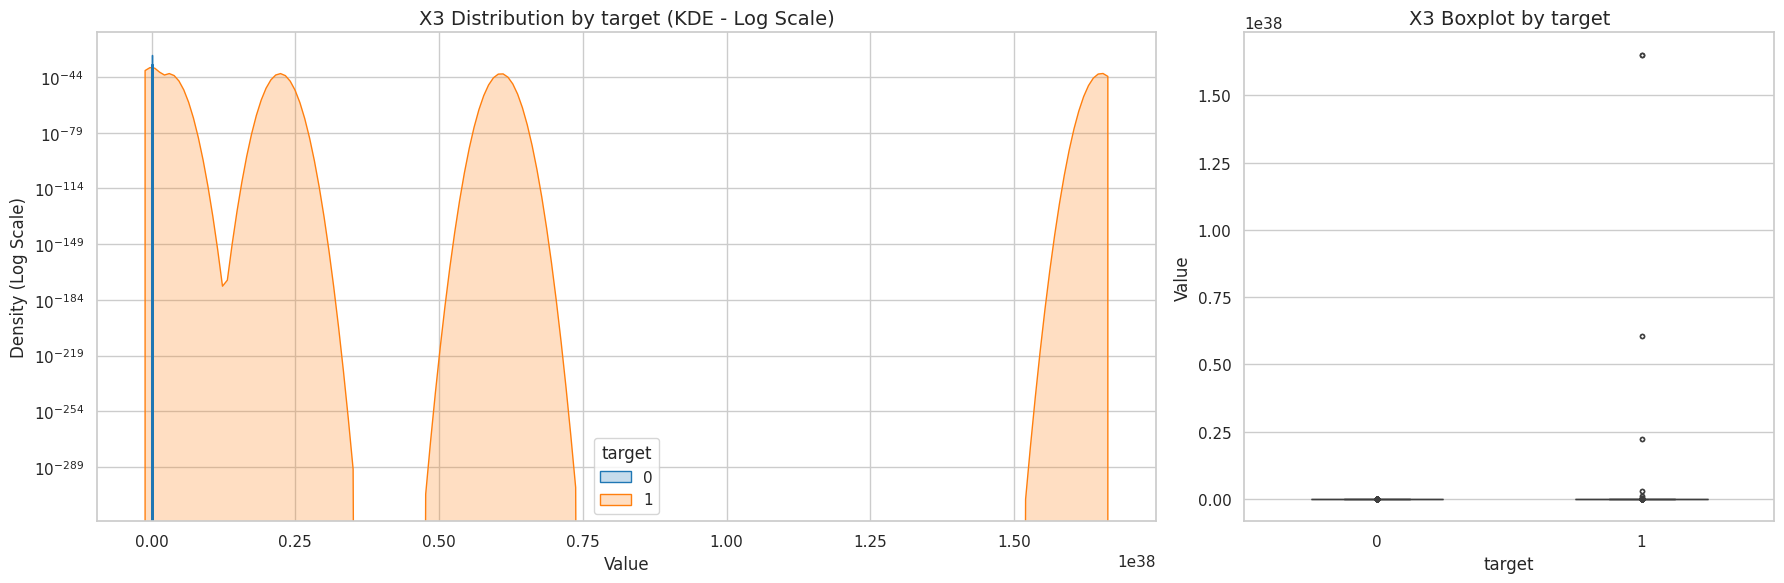


📌 X4 Summary Statistics by target:


,mean,median,std
target,,,
0,2.640087e+28,1.000000e+00,3.740500e+30
1,2.854890e+31,7.200490e+10,6.262798e+32


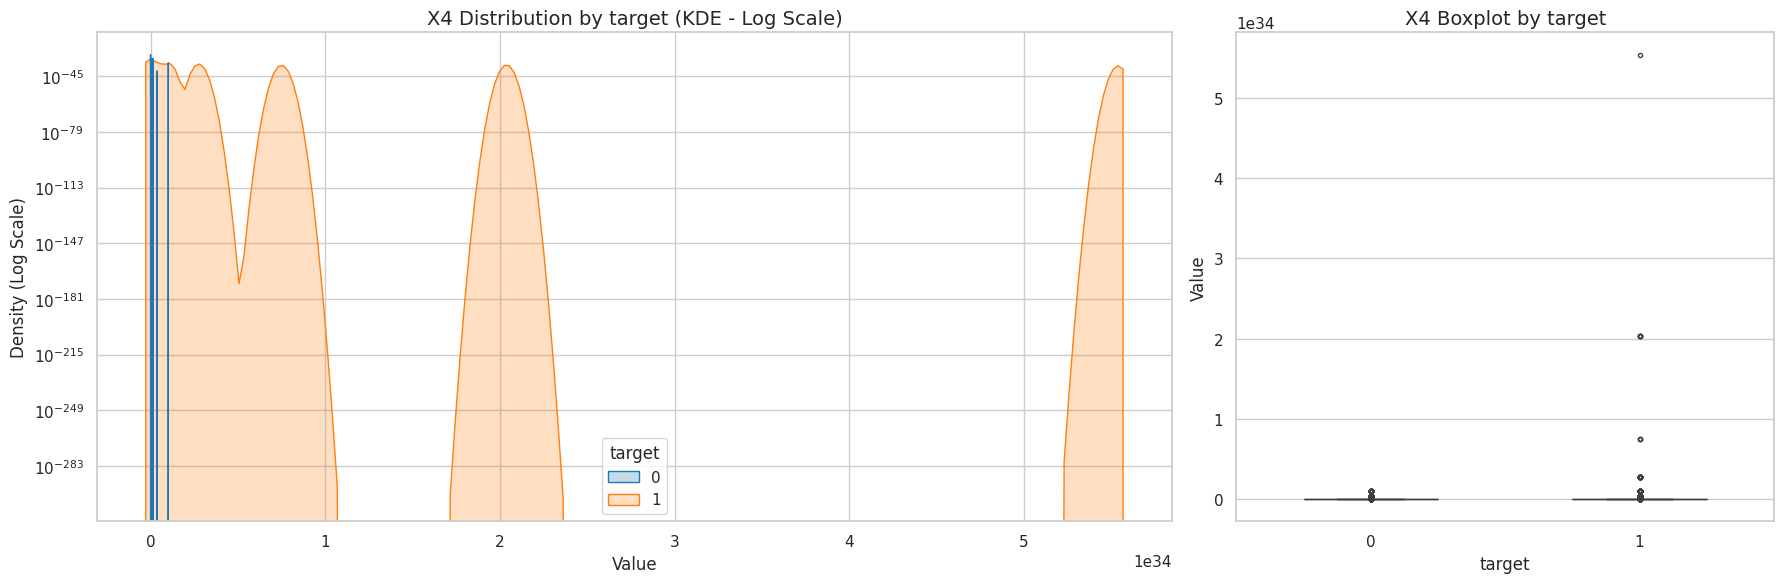


📌 X5 Summary Statistics by target:


,mean,median,std
target,,,
0,1.175329,0.693147,1.301316
1,2.563847,2.890372,0.920160


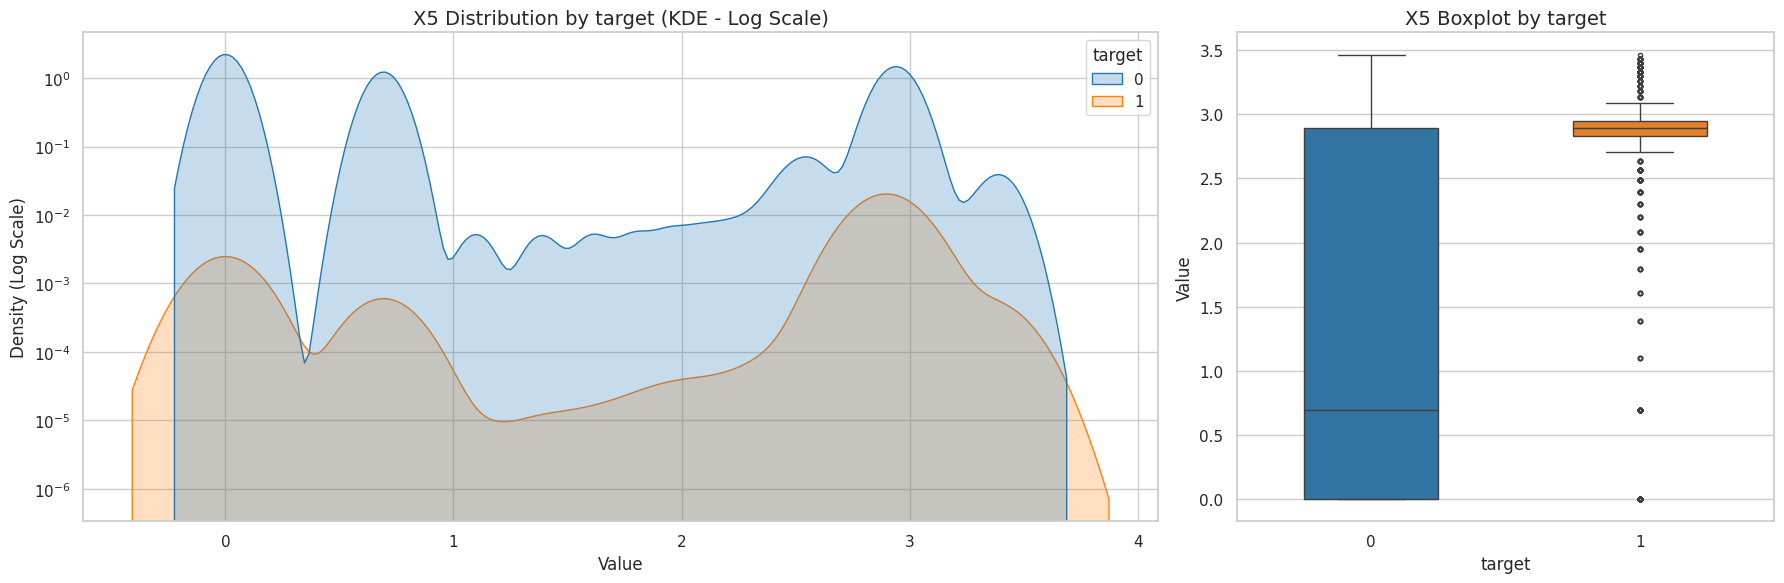

In [63]:
def plot_numerical_distributions(df, numerical_cols, target_col):
    """
    Generates KDE and box plots for numerical features, comparing distributions by target class,
    with summary statistics printed.
    """
    # sns.set_style("whitegrid") # Removed as it's set globally
    sns.set_context("notebook")

    # Convert target_col to category for better plotting
    df[target_col] = df[target_col].astype('category')

    # Use the globally defined my_palette for consistency
    # Map 0 to my_palette[0] and 1 to my_palette[1]
    current_palette = {str(0): my_palette[0], str(1): my_palette[1]}

    for col in numerical_cols:
        # Summary Stats grouped by target
        print(f"\n📌 {col} Summary Statistics by {target_col}:")
        display(df.groupby(target_col)[col].agg(['mean', 'median', 'std']))

        fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1]}) # Updated to global default figure size

        # KDE Plot
        sns.kdeplot(
            data=df, x=col, hue=target_col, ax=axes[0], fill=True, palette=current_palette
        )
        axes[0].set_title(f'{col} Distribution by {target_col} (KDE - Log Scale)', fontsize=14)
        axes[0].set_xlabel('Value')
        axes[0].set_ylabel('Density (Log Scale)')
        axes[0].set_yscale('log') # Apply logarithmic scale to y-axis

        # Box Plot
        sns.boxplot(
            data=df, y=col, x=target_col, ax=axes[1],
            orient='v', width=0.5, linewidth=1, fliersize=3, palette=current_palette
        )
        axes[1].set_title(f'{col} Boxplot by {target_col}', fontsize=14)
        axes[1].set_xlabel(target_col)
        axes[1].set_ylabel('Value')

        plt.tight_layout()
        plt.show()

# Call numerical distribution function with df_train and 'target'
plot_numerical_distributions(df_train, numerical_features, 'target')


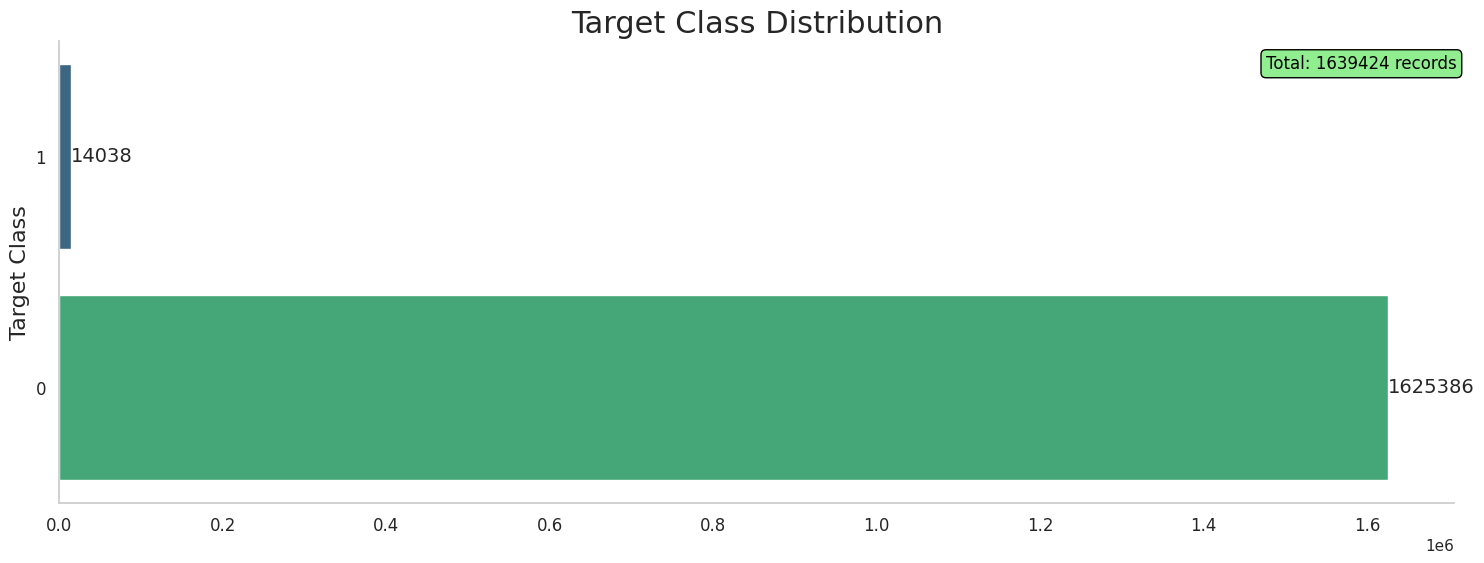

In [59]:
# View Target Class Distribution
fig = plt.figure(figsize=(18, 6))
plt.title('Target Class Distribution', fontsize=22);

status_distribution = df_train['target'].value_counts().sort_values()

bar_plot = sns.barplot(
    x=status_distribution.values,
    y=status_distribution.index.astype(str),
    palette="viridis",
    orient="h"
);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.ylabel('Target Class', fontsize=16);

text_params = {
    'x'       : status_distribution.max() * 0.98,
    'y'       : -0.4,
    's'       : f"Total: {len(df_train)} records",
    'size'    : 12,
    'color'   : "black",
    'ha'      : "center",
    'va'      : "center",
    'bbox'    : dict(boxstyle="round", fc=("lightgreen"),ec=("black"))
}
plt.text(**text_params);
plt.grid(False);
sns.despine();


# Analysis Report & Error Resolution

### 1. Error Resolution: Palette Dictionary
**Issue:** `ValueError: The palette dictionary is missing keys: {'0', '1'}`
**Cause:** The plotting function expected string keys for the palette, but received integer keys. This occurred because the `target` column, after conversion to a categorical type, uses string representations for its categories when passed to `hue`.
**Fix:** The palette dictionary has been updated to use string keys (`'0'` and `'1'`) instead of integer keys (`0` and `1`).

---

### 2. Numerical Feature Distribution Analysis
The analysis of numerical feature distributions by target class (**normal** vs. **anomaly**) is complete. Summary statistics and KDE/Box plots have been generated for features **X1** through **X5**.

#### Key Findings from Numerical Feature Distributions:

* **X1:**
    * **Anomalies (`target=1`):** Higher mean (**1.28**) and median (**1.24**) compared to normal instances (mean 1.14, median 1.11).
    * **Variability:** Standard deviation is higher for anomalies (**0.23** vs 0.14).
    * **Insight:** X1 tends to have higher values and more dispersion during anomalies.

* **X2:**
    * **Anomalies (`target=1`):** Mean and median are slightly lower (mean **5.46**, median **5.46**) compared to normal readings (mean 5.49, median 5.49).
    * **Variability:** Standard deviations are very similar.
    * **Insight:** X2 might slightly decrease during anomalies but without significant change in variability.

* **X3 & X4:**
    * **Anomalies (`target=1`):** Both features show extremely large means and standard deviations.
        * **X3:** Mean for `target=1` is **4.8e+34** (vs `target=0` at 9.8e+25). Median is **4.3e+15** (vs `target=0` at 1).
        * **X4:** Mean for `target=1` is **2.8e+31** (vs `target=0` at 2.6e+28). Median is **7.2e+10** (vs `target=0` at 1).
    * **Insight:** These features exhibit drastic shifts and potentially extreme outliers during anomalous periods, making them highly discriminative.

* **X5:**
    * **Anomalies (`target=1`):** Significantly higher mean (**2.56**) and median (**2.89**) compared to normal instances (mean 1.18, median 0.69).
    * **Variability:** Standard deviation for anomalies (**0.92**) is lower than for normal events (1.30).
    * **Insight:** Values are higher but potentially more concentrated around the mean during anomalies.

---

### 3. Overall Insights and Edge Cases

* **Clear Discriminative Features:** **X1, X3, X4,** and **X5** show strong differences in distributions (means, medians, spread) between normal and anomalous events. X3 and X4 are particularly indicative due to astronomical values during `target=1`.
* **Potential Outliers/Data Issues in X3 & X4:** The extreme values (e.g., means of $10^{34}$ and $10^{31}$) suggest massive shifts during faults or potential data encoding issues. These require investigation as they may need robust scaling or log transformation.
* **Feature Importance:** X1, X3, X4, and X5 are likely to be critical for the anomaly detection model. X2 is less discriminative individually but may offer value in combination with other features.
* **Model Selection Impact:** The extreme values in X3 and X4 favor models robust to outliers (e.g., Tree-based models like **XGBoost**) over distance-based models (KNN) or Neural Networks, unless careful scaling is applied.

---

### 4. Next Steps

1.  **Investigate Extreme Values:** Perform univariate outlier detection and consult domain knowledge regarding X3 and X4.
2.  **Feature Engineering - Transformations:** Explore transformations (e.g., log transformations) for X3/X4 to handle extreme scales.
3.  **Feature Engineering - Time-based Features:** Extract `hour`, `day_of_week`, `day_of_month`, `month`, and `year` from the 'Date' index. Apply cyclical features (sine/cosine) for periodicity.
4.  **Feature Engineering - Lagged Features:** Create lagged features for X1-X5 to capture short and medium-term dependencies.
5.  **Feature Engineering - Rolling Statistics:** Generate rolling mean, std, min, max, and median for X1-X5 to highlight deviations from recent operating conditions.
6.  **Feature Engineering - Rate of Change:** Calculate differences (deltas) for X1-X5 to capture sudden dynamic changes.
7.  **Data Scaling:** Apply `StandardScaler` or `MinMaxScaler` to numerical features to improve model convergence.
8.  **Class Imbalance Strategy:** Implement strategies such as SMOTE (oversampling), undersampling, or using sample weights/imbalance-robust algorithms.
9.  **Time-Series Preparation:** Structure the dataset to prevent data leakage, ensuring proper separation of features and targets for time-series modeling.

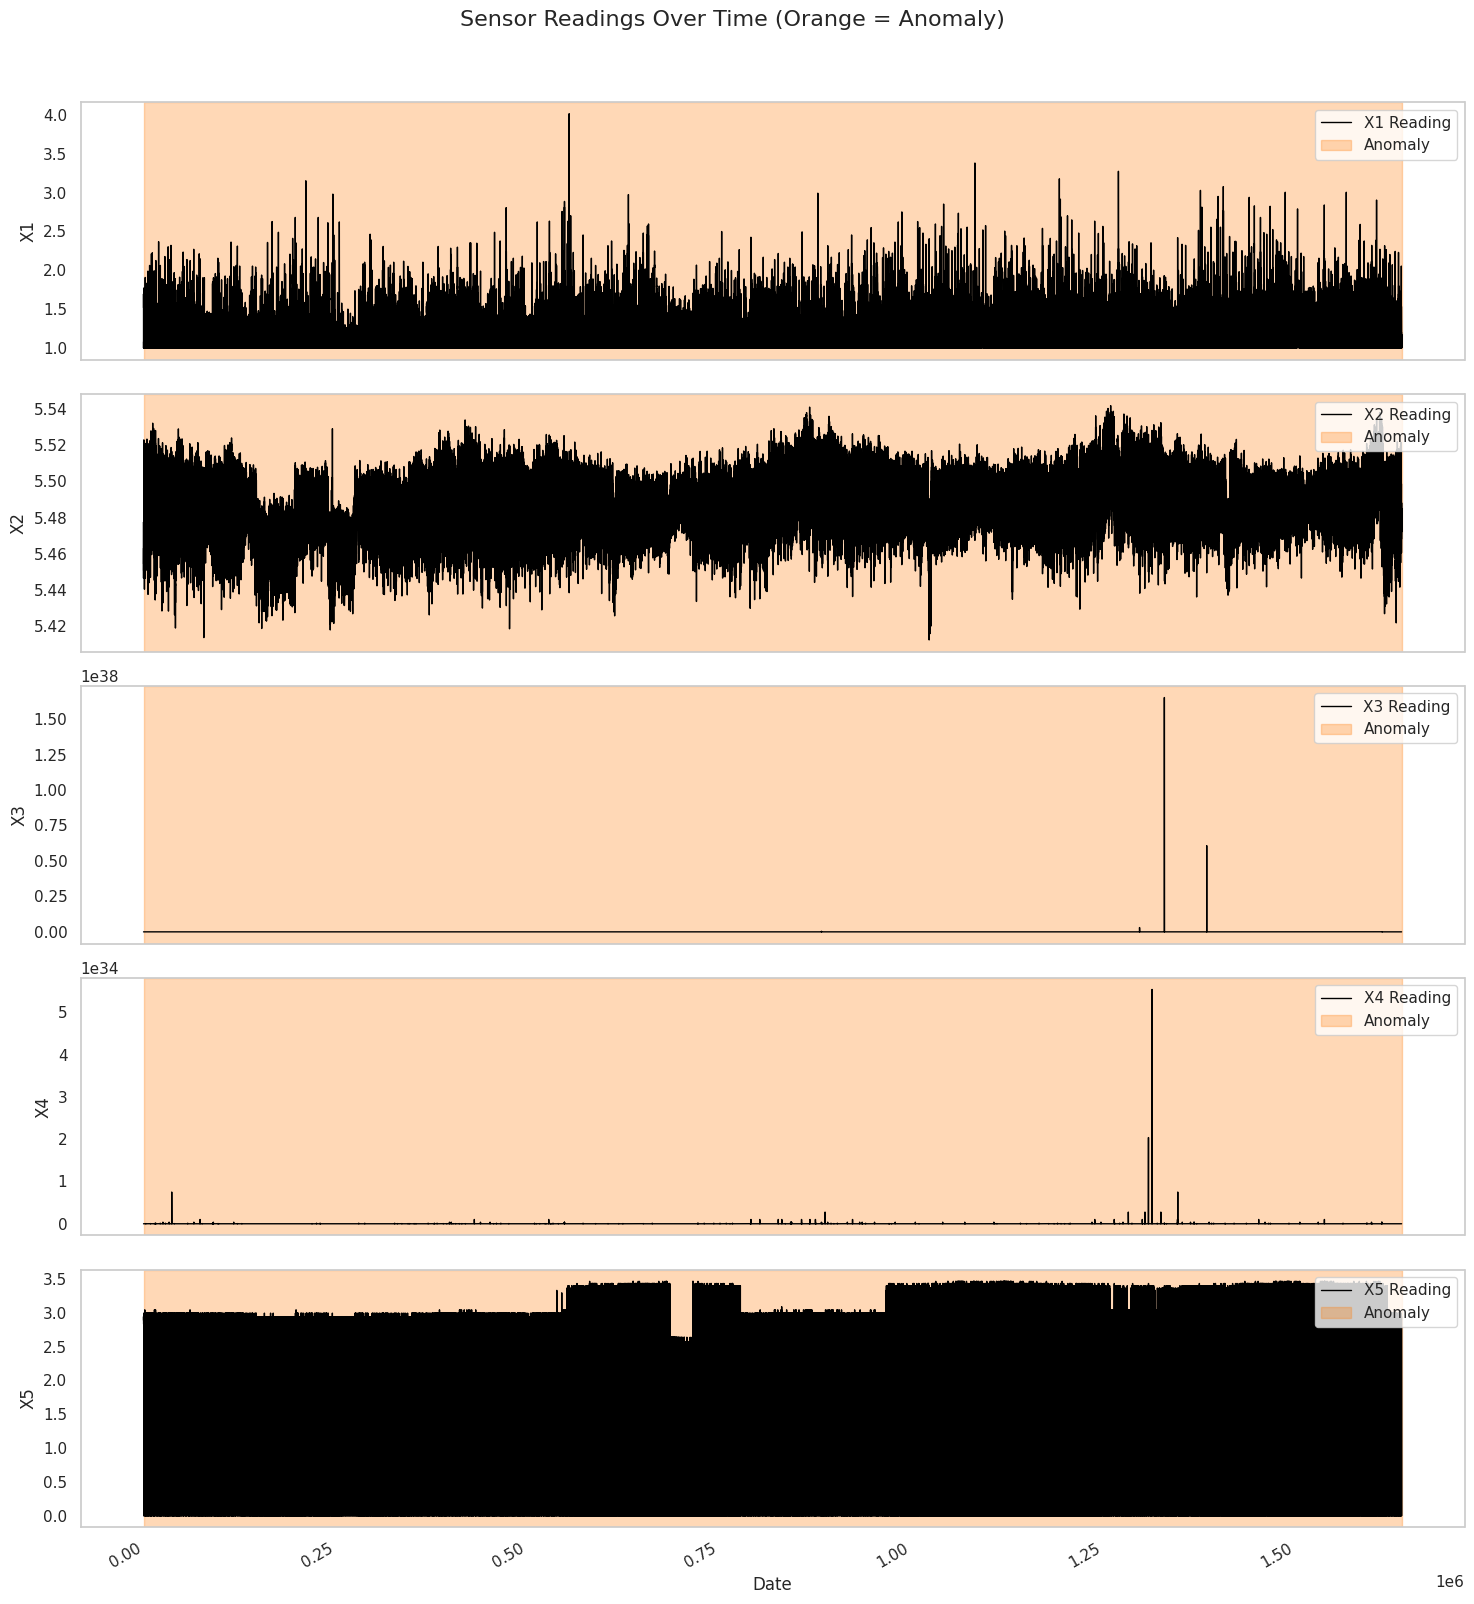

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Ensure `my_palette` exists, otherwise define a default for this cell
if 'my_palette' not in globals():
    my_palette = ['#1f77b4', '#ff7f0e']

# --- Optimized Anomaly Block Detection ---
anomalies = df_train['target'].astype(bool)

# Find start points of anomaly blocks (anomaly is True and previous is False)
start_dates = df_train.index[anomalies & ~anomalies.shift(1).fillna(False)]
# Find end points of anomaly blocks (anomaly is False and previous is True)
end_dates = df_train.index[~anomalies & anomalies.shift(1).fillna(False)]

anomaly_blocks = []
# Pair up starts and ends
start_idx_iter = iter(start_dates)
end_idx_iter = iter(end_dates)

current_start = next(start_idx_iter, None)
current_end = next(end_idx_iter, None)

while current_start is not None:
    # If anomaly starts at the beginning of the data
    if current_start == df_train.index[0] and current_end is None:
        # Anomaly starts at beginning and runs to end (or beyond)
        anomaly_blocks.append((current_start, df_train.index[-1]))
        break # No more starts/ends to process

    # If an anomaly started but hasn't ended yet (end_date > current_start)
    if current_end is None or current_end > current_start:
        # Look for the corresponding end date
        while current_end is not None and current_end <= current_start:
            current_end = next(end_idx_iter, None)

        if current_end is not None:
            anomaly_blocks.append((current_start, current_end))
            current_start = next(start_idx_iter, None)
            current_end = next(end_idx_iter, None)
        else: # Anomaly starts but doesn't end within the dataset
            anomaly_blocks.append((current_start, df_train.index[-1]))
            current_start = None # All starts processed or last one reaches end of data
    else:
        # Anomaly ended before a known start (this might happen if start was before df_train.index[0])
        # Just advance end_date and try again
        current_end = next(end_idx_iter, None)


# If the very first data point is an anomaly that continues from before index[0]
if anomalies.iloc[0] and (len(anomaly_blocks) == 0 or anomaly_blocks[0][0] != df_train.index[0]):
    # Find the end of this initial anomaly block
    first_end_of_initial_anomaly = next((e for s, e in anomaly_blocks if s == df_train.index[0]), None)
    if first_end_of_initial_anomaly is None and len(end_dates) > 0 and end_dates.iloc[0] == df_train.index[0]:
        # Anomaly at start, but first 'end' point is also at start, implying anomaly starts before data.
        # This case might be tricky; for simplicity, assume if anomalies.iloc[0] then it starts at df_train.index[0]
        pass
    else:
        # Ensure the first block starts from the very beginning if it's an anomaly
        if len(anomaly_blocks) > 0 and anomaly_blocks[0][0] > df_train.index[0]:
            anomaly_blocks.insert(0, (df_train.index[0], anomaly_blocks[0][0]))
        elif len(anomaly_blocks) == 0: # Case: entire dataset is an anomaly
            anomaly_blocks.append((df_train.index[0], df_train.index[-1]))

# Refined logic for initial anomaly block if it starts at the very first timestamp
if anomalies.iloc[0] and (not anomaly_blocks or anomaly_blocks[0][0] != df_train.index[0]):
    # Find the end of this initial anomaly (it will be the first 'end_date')
    first_end = next((e for e in end_dates if e > df_train.index[0]), df_train.index[-1]) # If no end, it runs to the end of data
    if not anomaly_blocks or anomaly_blocks[0][0] != df_train.index[0]: # Avoid adding duplicate if already present
        anomaly_blocks.insert(0, (df_train.index[0], first_end))

# --- Create Subplots ---
# Using figsize=(15, 18) for better vertical display of 5 plots, as used previously
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1, sharex=True, figsize=(15, 18))
fig.suptitle('Sensor Readings Over Time (Orange = Anomaly)', fontsize=16, y=0.92)

for i, col in enumerate(numerical_features):
    ax = axes[i]

    # Plot sensor value (black color, thin line)
    sns.lineplot(x=df_train.index, y=df_train[col], ax=ax, color='black', linewidth=1, label=f'{col} Reading')

    # Highlight anomaly regions with shaded background (orange color from my_palette[1])
    for j, (start_date, end_date) in enumerate(anomaly_blocks):
        ax.axvspan(start_date, end_date, color=my_palette[1], alpha=0.3,
                   label='Anomaly' if j == 0 else "") # Label only the first block for the legend

    ax.set_ylabel(col)
    ax.legend(loc='upper right')
    ax.grid(False) # No grid

    # Add date label only to the bottom-most subplot if sharing x-axis
    if i == len(numerical_features) - 1:
        ax.set_xlabel('Date')
    else:
        ax.set_xlabel('') # Clear xlabel for upper subplots

# Ensure x-axis dates are readable
fig.autofmt_xdate()

plt.tight_layout(rect=[0, 0.03, 1, 0.9]) # Adjust layout to prevent title overlap
plt.show()
